In [1]:
pip install pyodbc pandas openpyxl

In [5]:
import pyodbc
import pandas as pd

# Connect to your SQL Server
conn = pyodbc.connect(
    r'DRIVER={ODBC Driver 17 for SQL Server};'
    r'SERVER=LAPTOP-82HJ41IA\SQLEXPRESS;'
    r'DATABASE=ProductInsightsDB;'
    r'Trusted_Connection=yes;'
)

cursor = conn.cursor()

# Load Excel files
products = pd.read_excel(r"C:\Users\RAMITHA\Downloads\Product_Master.xlsx")
orders = pd.read_excel(r"C:\Users\RAMITHA\Downloads\Orders.xlsx")

# Insert Product Data
for index, row in products.iterrows():
    cursor.execute("""
        INSERT INTO ProductMaster (ProductID, ProductName, Category, Price, StockQty)
        VALUES (?, ?, ?, ?, ?)
    """, row['ProductID'], row['ProductName'], row['Category'], row['Price'], row['StockQty'])

# Insert Order Data
for index, row in orders.iterrows():
    cursor.execute("""
        INSERT INTO Orders (OrderID, ProductID, OrderDate, Quantity, Region)
        VALUES (?, ?, ?, ?, ?)
    """, row['OrderID'], row['ProductID'], row['OrderDate'], row['Quantity'], row['Region'])

conn.commit()
print("Data inserted successfully!")

Data inserted successfully!


In [11]:
# 4️⃣ Fetch Data for Analysis
query = """
SELECT o.OrderID, o.ProductID, p.ProductName, p.Category, p.Price, 
       o.OrderDate, o.Quantity, o.Region
FROM Orders o
JOIN ProductMaster p ON o.ProductID = p.ProductID;
"""

df = pd.read_sql(query, conn)

# 5️⃣ Data Analysis

# Add Total Sales Column
df['TotalSales'] = df['Price'] * df['Quantity']

# Convert OrderDate to datetime format
df['OrderDate'] = pd.to_datetime(df['OrderDate'])

# Group by Month
monthly = df.groupby(df['OrderDate'].dt.to_period('M')).agg({
    'TotalSales': 'sum',
    'Quantity': 'sum'
}).reset_index()

# Convert Period to Timestamp for plotting
monthly['OrderDate'] = monthly['OrderDate'].dt.to_timestamp()

# Show final monthly analysis
print("Monthly Sales Summary:")
print(monthly)

# Optional: Save monthly summary to CSV for Power BI
monthly.to_csv("MonthlySalesSummary.csv", index=False)

Monthly Sales Summary:
   OrderDate  TotalSales  Quantity
0 2025-07-01       52849        51


C:\Users\RAMITHA\AppData\Local\Temp\ipykernel_9768\3664079670.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [9]:
from sqlalchemy import create_engine
import urllib

params = urllib.parse.quote_plus(
    "DRIVER={ODBC Driver 17 for SQL Server};"
    "SERVER=LAPTOP-82HJ41IA\\SQLEXPRESS;"
    "DATABASE=ProductInsightsDB;"
    "Trusted_Connection=yes;"
)

engine = create_engine(f"mssql+pyodbc:///?odbc_connect={params}")

# Now run the same query with SQLAlchemy engine
df = pd.read_sql(query, engine)

In [17]:
# 4️⃣ Fetch Data for Analysis
from sqlalchemy import create_engine
import urllib

params = urllib.parse.quote_plus(
    "DRIVER={ODBC Driver 17 for SQL Server};"
    "SERVER=LAPTOP-82HJ41IA\\SQLEXPRESS;"
    "DATABASE=ProductInsightsDB;"
    "Trusted_Connection=yes;"
)

engine = create_engine(f"mssql+pyodbc:///?odbc_connect={params}")

# Now run the same query with SQLAlchemy engine
df = pd.read_sql(query, engine)
query = """
SELECT o.OrderID, o.ProductID, p.ProductName, p.Category, p.Price, 
       o.OrderDate, o.Quantity, o.Region
FROM Orders o
JOIN ProductMaster p ON o.ProductID = p.ProductID;
"""


# 5️⃣ Data Analysis

# Add Total Sales Column
df['TotalSales'] = df['Price'] * df['Quantity']

# Convert OrderDate to datetime format
df['OrderDate'] = pd.to_datetime(df['OrderDate'])

# Group by Month
monthly = df.groupby(df['OrderDate'].dt.to_period('M')).agg({
    'TotalSales': 'sum',
    'Quantity': 'sum'
}).reset_index()

# Convert Period to Timestamp for plotting
monthly['OrderDate'] = monthly['OrderDate'].dt.to_timestamp()

# Show final monthly analysis
print("Monthly Sales Summary:")
print(monthly)

# Optional: Save monthly summary to CSV for Power BI
monthly.to_csv("MonthlySalesSummary.csv", index=False)

Monthly Sales Summary:
   OrderDate  TotalSales  Quantity
0 2025-07-01       52849        51


In [19]:
print("Total rows in df:", len(df))
print("Total rows in monthly summary:", len(monthly))

Total rows in df: 20
Total rows in monthly summary: 1


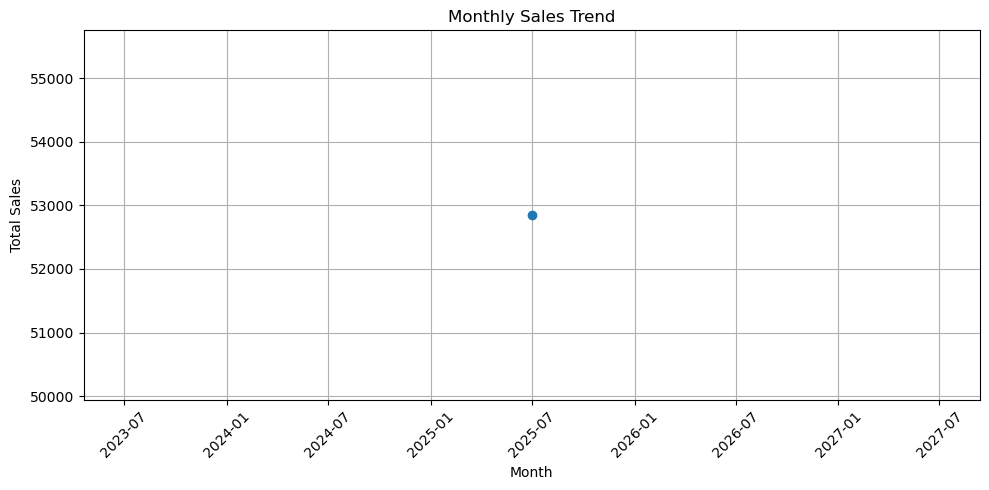

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(monthly['OrderDate'], monthly['TotalSales'], marker='o')
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
query = "SELECT COUNT(*) AS TotalRows FROM Orders"
count_df = pd.read_sql(query, engine)
print("Total rows in Orders table:", count_df.iloc[0]['TotalRows'])

Total rows in Orders table: 20


In [29]:
# Example: Randomly distribute OrderDate across 3 months
import numpy as np
df['OrderDate'] = np.random.choice(pd.date_range('2025-06-01', '2025-08-31'), size=len(df))

In [31]:
# Convert OrderDate to datetime if not already done
df['OrderDate'] = pd.to_datetime(df['OrderDate'])

# Group by month and calculate total sales and quantity
monthly = df.groupby(df['OrderDate'].dt.to_period('M')).agg({
    'TotalSales': 'sum',
    'Quantity': 'sum'
}).reset_index()

# Convert Period back to Timestamp for plotting
monthly['OrderDate'] = monthly['OrderDate'].dt.to_timestamp()

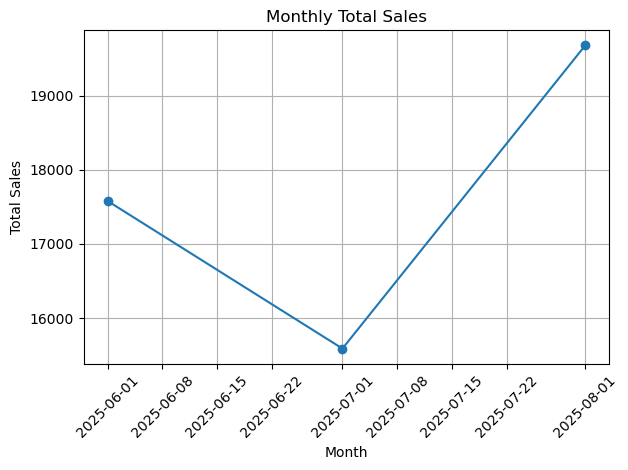

In [33]:
import matplotlib.pyplot as plt

plt.plot(monthly['OrderDate'], monthly['TotalSales'], marker='o')
plt.title('Monthly Total Sales')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

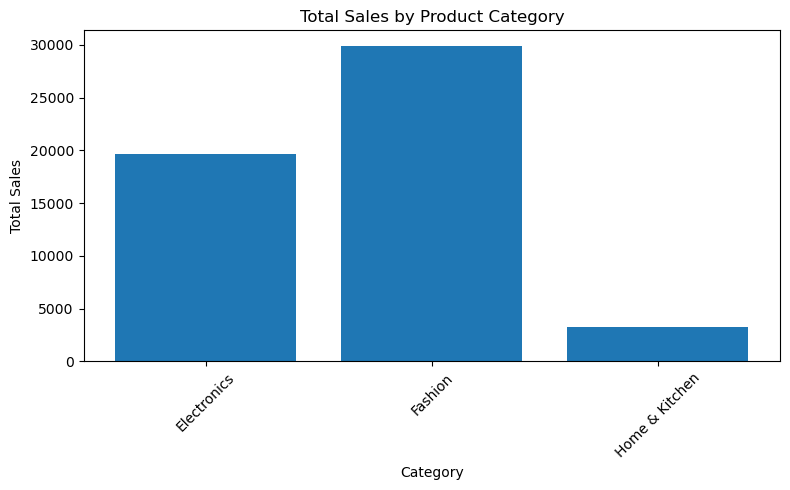

In [35]:
import matplotlib.pyplot as plt

category_sales = df.groupby('Category')['TotalSales'].sum().reset_index()

plt.figure(figsize=(8, 5))
plt.bar(category_sales['Category'], category_sales['TotalSales'])
plt.xlabel('Category')
plt.ylabel('Total Sales')
plt.title('Total Sales by Product Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

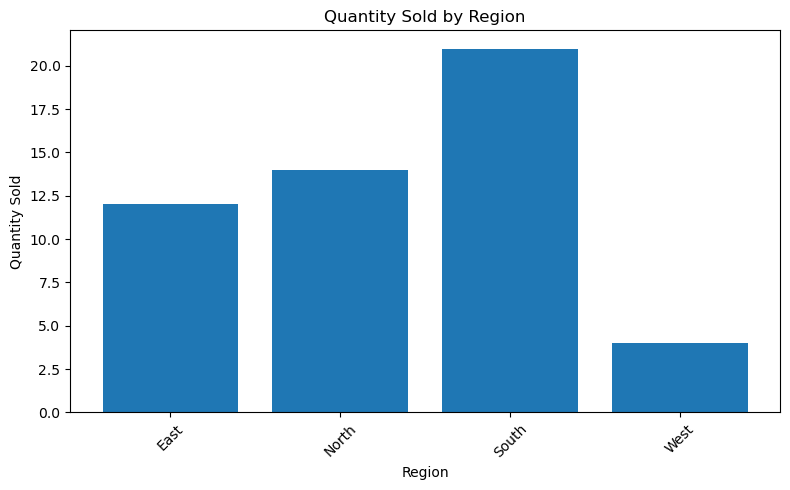

In [37]:
region_qty = df.groupby('Region')['Quantity'].sum().reset_index()

plt.figure(figsize=(8, 5))
plt.bar(region_qty['Region'], region_qty['Quantity'])
plt.xlabel('Region')
plt.ylabel('Quantity Sold')
plt.title('Quantity Sold by Region')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

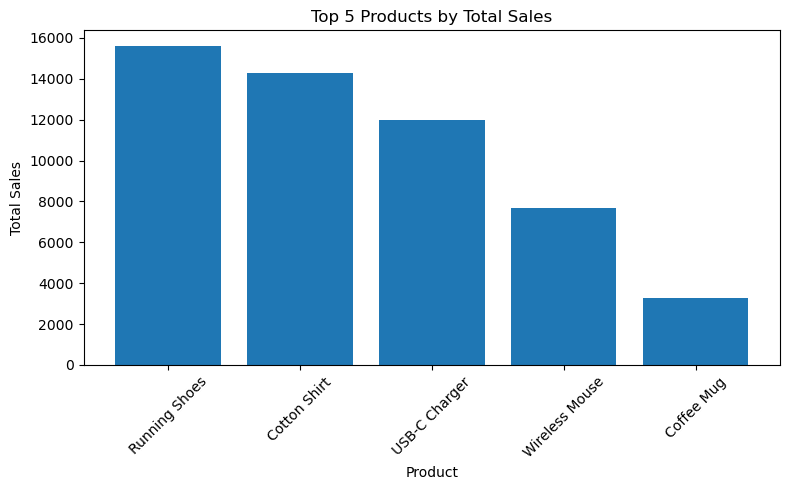

In [39]:
top_products = df.groupby('ProductName')['TotalSales'].sum().nlargest(5).reset_index()

plt.figure(figsize=(8, 5))
plt.bar(top_products['ProductName'], top_products['TotalSales'])
plt.xlabel('Product')
plt.ylabel('Total Sales')
plt.title('Top 5 Products by Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

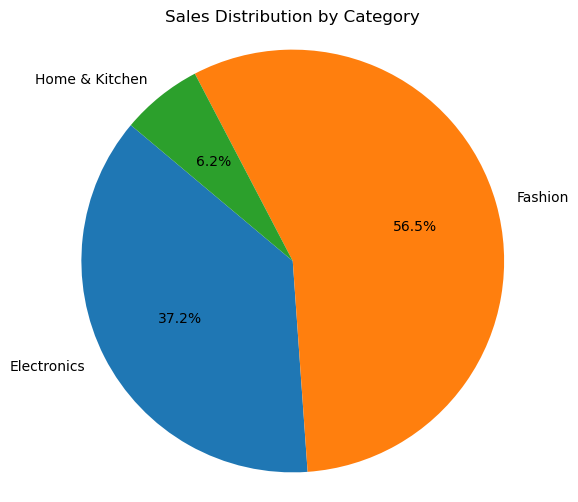

In [41]:
category_sales = df.groupby('Category')['TotalSales'].sum()

plt.figure(figsize=(6, 6))
plt.pie(category_sales, labels=category_sales.index, autopct='%1.1f%%', startangle=140)
plt.title('Sales Distribution by Category')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.show()